# Problem 1: nearest neighbors for data imputation

Real-world datasets often have missing values: this can be due to hardware faults (e.g., a sensor failing), data corruption, ambiguity, or even by design (think about surveys with optional questions). In Python, the special value `NaN` (not-a-number) can be used to indicate a missing value.

Dealing with missing data is not straightforward. One option is to *remove* any sample with missing features $x_{i}$ (or label $y$). However, there are several datasets for which *almost all* samples have one or more missing feature values, and we would be throwing away all the information contained in the non-missing values.

In this problem, we explore the use of the $k$-nearest neighbors algorithm for *data imputation*.

## Question 1

> Suppose that you are solving a regression problem where **the only potential missing values are response labels $y^{(i)}$**. Describe a method, based on the $k$-nearest neighbors algorithm, to fill-in missing values based on the available response labels. When do you expect your method to work well, and when do you expect it to produce poor results? Justify your answers and design choices.

We can handle missing responses using k-nearest neighbors imputation. For each example with a missing y, we can find its k most similar examples based on the feature values and fill in the missing response with the average of their observed responses. This approach works well when similar feature vectors have similar responses and when only a small, random fraction of responses is missing. It can perform poorly if the features don’t predict the response well or if the missing values are systematically different, which could bias the results. We can use the average to keep the estimate stable and choose k to balance locality (small k) and smoothness (large k).

## Question 2
> Implement your method from Question 1 by completing the provided code snippet in `p1.py` (in the `KnnLabelImputer` class) and **submit it to Gradescope**. You can use the `regression_dataset_with_missing_responses` function, provided in the next code cell, to generate example inputs to help with development.

`p1.py` attached separately.

## Question 3
> Now, suppose that we are solving a *classification* problem, and we know that *no labels $y^{(i)}$ are missing*. However, there are now missing *feature* values. Like in **Question 1**, describe a method based on the $k$-nearest neighbors algorithm for performing data imputation on the features of the dataset. You can assume that there are enough samples for each distinct class label. When do you expect your method to work well, and when not to? Justify your answers and design choices.

> **Tip**: The nearest neighbors implementation in `scikit-learn` allows you to define your own distance function via the `metric` parameter. You can use this to define a distance function that takes into account missing values and class membership. Think about how you can modify the distance function to favor samples with the same class label.

We can handle missing feature values using a k-nearest neighbors imputation method that leverages the fact that labels are fully known. For each sample with missing features, we can search for neighbors only within the same class to ensure that the imputation reflects class-specific patterns. For each missing feature, we can then replace it with the average value (for numerical features) or the most common value (for categorical features) among the k nearest neighbors of the same label.

This approach works well when feature values within each class are internally consistent and when there are enough samples per class to find meaningful neighbors. It can perform poorly if different classes have very similar feature distributions, making same-label restriction less useful, or if many features are missing, making it difficult to measure similarity reliably.

## Question 4
> Implement your method from Question 3 by completing the provided code template in `p1.py` (in the `KnnFeatureImputer` class) and **submit it to Gradescope**. You can use the `classification_dataset_with_missing_features` function from the following cell to generate example inputs to help with development.

`p1.py` attached separately.

In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification


def regression_dataset_with_missing_responses(
    n_samples: int, n_features: int, p_missing: float = 0.1
):
    """
    Generate a regression dataset with missing responses.

    Args:
        n_samples: Number of samples.
        n_features: Number of features.
        p_missing: Probability of missing a response.

    Returns:
        A Pandas DataFrame with features and a response column.
    """
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
    )
    # Replace response values by NaN with probability p_missing.
    y = np.where(np.random.rand(*y.shape) < p_missing, np.nan, y)
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    return pd.concat([X, pd.Series(y, name="response")], axis=1)


def classification_dataset_with_missing_features(
    n_samples: int, n_features: int, p_missing: float = 0.1, n_classes: int = 3
):
    """
    Generate a classification dataset with missing features.

    Args:
        n_samples: Number of samples.
        n_features: Number of features.
        p_missing: Probability of missing a feature.
        n_classes: Number of classes.

    Returns:
        A Pandas DataFrame with features and a label column.
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_clusters_per_class=1,
    )
    # Replace feature values in X by NaN with probability p_missing.
    X = np.where(np.random.rand(*X.shape) < p_missing, np.nan, X)
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    return pd.concat([X, pd.Series(y, name="label")], axis=1)

In [25]:
# Example: regression dataset with 500 samples 20 features, and approximately 10% of responses missing
dataset = regression_dataset_with_missing_responses(500, 10, p_missing=0.1)
dataset.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,response
0,-1.164810,-0.226387,0.050557,-0.669245,-0.659123,-0.068306,-0.984294,1.043431,-0.520017,0.478125,-156.220809
1,0.102553,1.195287,-0.129164,0.895177,-0.839248,0.638248,-1.067251,-1.355740,0.238173,0.313817,-54.917286
2,-0.390013,0.345665,-0.428226,0.412531,0.862226,1.469310,1.132543,-0.915017,0.415426,-0.940244,57.603668
3,-0.070079,-0.039998,0.882647,1.065297,1.425793,0.554530,-0.927606,0.837074,-1.234294,-0.166164,12.177221
4,0.776351,2.311493,1.672946,1.052449,0.785749,1.725888,-1.021354,-0.349760,1.275899,1.577549,505.651737


In [26]:
# Example: classification dataset with 500 samples 10 features, and 10% of responses missing
dataset = classification_dataset_with_missing_features(500, 10, p_missing=0.1)
dataset.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,0.730404,1.037633,-1.406930,0.802616,0.078468,-3.745379,1.020923,0.729439,1.272718,-4.205551,1
1,-1.448873,-1.427651,-0.268026,0.872633,-0.104263,0.999757,1.221621,0.415734,-0.618494,2.117848,0
2,0.349807,0.295780,0.114803,-0.030483,0.340912,0.257209,1.380472,0.259677,-1.096019,-0.028653,1
3,-1.333224,-1.350038,NaN,-0.270142,-1.009224,NaN,-0.795650,-1.954413,0.420495,NaN,0
4,-0.869813,-0.745964,-1.366194,-0.164417,1.192395,-0.532596,-0.673730,-0.157810,0.817507,0.174799,2


# Problem 2: cross-validation for imbalanced datasets

In class, we discussed the use of cross-validation to estimate model performance on unseen data. However, extra care must be taken in cases where our data is *unbalanced*. This is best explained via a cautionary (fictional) tale.


> An aerospace engineer is tasked with creating and fine-tuning a classifier that processes post-flight images of aircraft wings and screens them for the presence of fractures. To train the classifier, they are given access to a dataset of labeled images ($0$ indicates no fracture, $1$ indicates fracture). Following the advice of an LLM, the engineer writes a `scikit-learn` pipeline that:
>
> - pre-processes the data, splits them into $K = 20$ folds using the built-in `KFold` class
> - trains several logistic regression models, one for each fold, and
> - selects the best model based on the estimated (via cross-validation) F1 score.
>
> However, 5 years after they deploy their model, maintenance engineers suggest that it failed to detect several fractures, leading to higher degradation of the aircraft and many more dollars lost. **What went wrong?**


A likely answer is that the dataset is very imbalanced. Specifically, wings are usually structurally intact after flight; unless special care was taken while curating the dataset, most labels will be negative and many folds will not contain any samples from the positive class. Therefore, it is possible that a classifier that always outputs "negative" leads to good F1 score as estimated via cross-validation.

To fix this, we augment K-fold cross validation with the idea of **stratified** sampling. Stratified sampling splits the data in a way that approximately preserves the fraction of class labels within each fold. In `scikit-learn`, this is easy to implement via the `StratifiedKFold` class.

## Question 1

> Use the provided function `make_imbalanced_classification_dataset()` below to generate datasets with 500 samples and 50 features. Train a logistic regression classifier using (a) `KFold` and (b) `StratifiedKFold` cross-validation for different values of $K$, and plot the resulting F1 score as a function of the number of folds $K$. Are the results expected or surprising, and why?

> **Note**: you can implement the cross-validation yourself or use the built-in `cross_val_score` function from `scikit-learn` or use the `LogisticRegressionCV` model with the appropriate cross-validation generator.

Code cell and plot are at the end of this problem.

The results are expected, as `KFold` on imbalanced data can product unreliable estimates because some folds may not contain any positive samples. As K increases, the likelihood of having folds without positive samples also increases, leading to misleadingly high F1 scores. In contrast, `StratifiedKFold` maintains the class distribution across folds, resulting in more reliable and consistent F1 score estimates regardless of the number of folds.

On the plot, we see that the orange line (StratifiedKFold) starts higher and declines more gradually as K increases, while the blue line (KFold) starts lower and declines more steeply. This indicates that StratifiedKFold provides a more stable and accurate estimate of model performance on imbalanced datasets. The F1 score decreases for both methods as K increases because as K increases, each fold contains fewer samples, making it harder for the model to learn effectively during training, which can lead to overfitting and reduced generalization performance. The difference in StratifiedKFold is less pronounced because it maintains class distribution, helping to mitigate the negative effects of smaller training sets.

## Question 2
> Another potential approach is to adjust the classification threshold (instead of the default $\frac{1}{2}$). For example, we can make the classifier much more conservative by outputting a positive label after a threshold of $\frac{1}{10}$. Do you think this is a good idea? Why or why not?

If we lower the threshold to 1/10, the model will label more points as positive, which will increase recall to catch more true positives, but also decrease precision by introducing more false positives. In this situation of fracture detection on aircraft wings, missing a fracture as a false negative will have serious consequences, so the trade-off of catching more fractures at the cost of more false alarms is a good idea.

In [27]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd


def make_imbalanced_classification_dataset(
    n_samples: int, n_features: int, class_imbalance: float
) -> pd.DataFrame:
    """
    Make an imbalanced classification dataset.

    Args:
        n_samples: The number of samples.
        n_features: The number of features.
        class_imbalance: The proportion of samples assigned to each class.
    """
    if class_imbalance <= 0 or class_imbalance >= 1:
        raise ValueError("class_imbalance must be between 0 and 1")
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=2,
        weights=[class_imbalance, 1 - class_imbalance],
    )
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    return pd.concat([X, pd.Series(y, name="label")], axis=1)

In [28]:
dataset = make_imbalanced_classification_dataset(100, 10, 0.1)
dataset.head(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,0.920163,1.138670,0.452324,0.781797,0.038009,1.225907,0.486435,0.778323,-0.829658,0.402049,1
1,-0.629302,0.404929,-0.355558,-1.150306,0.754497,0.718136,0.828728,-0.201574,-0.333686,0.455590,1
2,-1.779383,2.260362,-1.212848,0.183384,-1.928795,1.670270,-1.864012,0.751936,1.022422,-0.047478,1
3,1.564097,1.385532,0.491955,0.214628,-0.762445,1.183711,-0.496969,2.253041,-1.071552,0.148028,1
4,-0.286278,-0.090144,0.371121,1.022884,0.685745,0.165245,0.330204,-0.079645,-0.634978,0.258753,1
5,0.050388,2.400569,-0.698305,0.874773,-2.513251,1.596861,-1.104138,0.091954,-1.082885,-0.246526,1
6,-0.927169,-0.228665,1.578509,-0.591260,0.236916,-0.153053,-0.276253,-1.664905,-0.673423,0.022435,1
7,-0.573638,1.360001,0.884564,1.085719,-1.447684,0.895593,-0.215690,-1.111405,1.347554,-0.149725,1
8,-0.342165,2.341515,0.162222,0.613883,-1.962841,1.743643,-0.234986,-1.408380,-0.724664,-0.034330,1
9,-0.619632,-1.745148,-0.637569,-0.257003,1.173123,-1.409911,0.733007,-0.968899,-0.731124,-0.096677,0


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/hw1/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/hw1/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/hw1/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_divisio

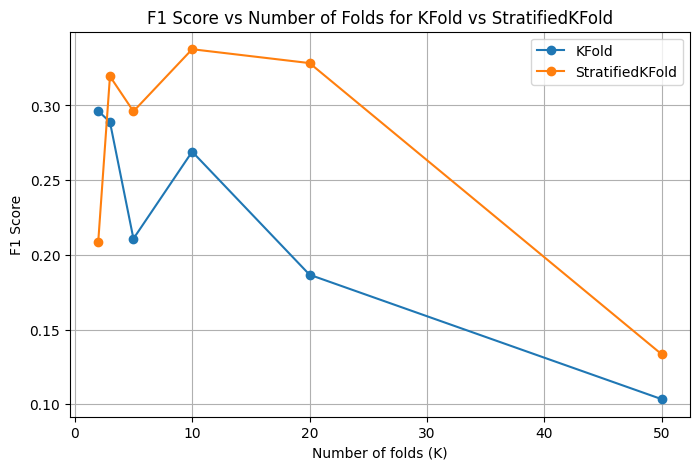

In [29]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# create imbalanced dataset of 95% negatives and 5% positives
df = make_imbalanced_classification_dataset(
    n_samples=500,
    n_features=50,
    class_imbalance=0.95
)

X = df.drop(columns=["label"]).values
y = df["label"].values

# define a logistic regression model and F1 scorer from sklearn
model = LogisticRegression(max_iter=1000)
f1_scorer = make_scorer(f1_score)

# try different K values for KFold and StratifiedKFold
k_values = [2, 3, 5, 10, 20, 50]
kf_scores = []
skf_scores = []

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores_kf = cross_val_score(model, X, y, cv=kf, scoring=f1_scorer)
    kf_scores.append(scores_kf.mean())

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores_skf = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer)
    skf_scores.append(scores_skf.mean())

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, kf_scores, marker='o', label='KFold')
plt.plot(k_values, skf_scores, marker='o', label='StratifiedKFold')
plt.xlabel('Number of folds (K)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Folds for KFold vs StratifiedKFold')
plt.legend()
plt.grid(True)
plt.show()

# Problem 3: dimension reduction via random projections

In class, we discussed how PCA discovers a few important degrees of freedom of high-dimensional datasets.

The main idea was the following:

> *If data are mostly contained on a low-dimensional subspace, let's discover that subspace and project the data onto it.*

The number of principal components, $k$ reflects our "guess" for the dimension of that subspace.

Another dimension reduction method featuring prominently in theoretical computer science is that of so-called "random projections". Setting the stage, suppose we have $n$ data points living in $d$-dimensional space ($\mathbb{R}^d$ for simplicity). The random projections method proceeds as follows:

- Generate $k$ vectors, $g^{(1)}, \dots, g^{(k)}$, randomly (often according to a Gaussian distribution).
- Arrange these vectors as the columns of a matrix:

$$
\Pi := \begin{bmatrix}
	g^{(1)} & \cdots & g^{(k)}
\end{bmatrix} \in \mathbb{R}^{d \times k}.
$$

- For each of the $n$ points in your dataset, say $x^{(1)}, \dots, x^{(n)}$:
	- Compute the product $\widetilde{x}^{(i)} = \Pi^{\top} x^{(i)}$.
- This results in a matrix $\widetilde{X} \in \mathbb{R}^{n \times k}$ containing the "reduced" dataset.
- Downstream tasks (e.g., regression or classification) can be performed on the reduced dataset instead.
    - Any new data point $x$ can be projected to $\widetilde{x} := \Pi^{\top} x$.


The random projections method works because the matrix $\Pi$ produces "low distortion": for all pairs $i \neq j$,

$$
(1 - \varepsilon) \|x^{(i)} - x^{(j)}\| \leq \| \widetilde{x}^{(i)} - \widetilde{x}^{(j)}\| \leq (1 + \varepsilon) \|x^{(i)} - x^{(j)}\|,
$$

whenever the number of the random vectors $k$ satisfies the following inequality:

$$
k \geq \frac{10 \log(n)}{\varepsilon^2}.
$$

> Note that the ambient dimension, $d$, **does not appear** in the bound at all! This result is known in the literature as the *Johnson-Lindenstrauss lemma*.

In this exercise, you will explore the use of random projections with 2 different variants: one where the random vectors are dense, and one where the random vectors are *sparse* (i.e., mostly zeros). Then, you will compare the quality of the resulting embeddings with that provided by principal component analysis.

## Question 1

Download the code template `p3.py`. You will find two functions with the following code signatures:

```python
def apply_sparse_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
	...
	
def apply_dense_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
	...
```

These functions accept a `dataset` (e.g., a Numpy table) where each row is a sample and the number of projections $k$, `num_projections`. They should return the reduced dataset after applying the random projections method. Implement both methods and submit your code to Gradescope.

> **Tip**: Use the `SparseRandomProjection` and `GaussianRandomProjection` classes from `scikit-learn`. You will have to instantiate them with the appropriate arguments.

## Question 2 

Use the provided snippet below to create a high-dimensional dataset. Using your implementation from Question 1, compute the following quantities for $k = 2^{j}$ ($j = 2, \dots, 10$):

- **Maximum and minimum distortion**: the min and max ratio of distances between projected and original data points.

  $$
  \gamma_{\mathsf{upper}} := \max_{i \neq j} d_{i, j} \;\; \text{and} \;\; \gamma_{\mathsf{lower}} := \min_{i \neq j} d_{i, j},
  $$
  
  where we define the ratios $d_{i,j}$ as follows:
  
  $$
  \frac{\|\widetilde{x}^{(i)} - \widetilde{x}^{(j)}\|}{\|x^{(i)} - x^{(j)}\|}.
  $$

- The ratio $\sqrt{\frac{\lceil \log n \rceil}{k}}$.

Make a plot of these quantities as a function of $k$ (once for sparse and once for dense random projections). In your narrative writeup, discuss the following questions:

- Is the behavior of these quantities surprising as you increase $k$? Why or why not?
- Is the behavior of these quantities surprising as you move from sparse to dense random projections? Why or why not?
- Would you recommend this method for a huge dataset (very large $n$) of relatively small dimension ($d$)? Why or why not?

**Answer:**

The behavior as k increases is not surprising and it matches the Johnson-Lindenstrauss lemma, which states that as k increases, the distortion factors should approach 1. This is because with more projections, the random projection better preserves the distances between points. As k grows, both sparse and dense projections show that maximum distortion decreases and minimum distortion increases, indicating better distance preservation.

Further, the behavior when moving from sparse to dense projections is also not surprising. Dense projections tend to preserve distances better than sparse ones because they utilize more information from the original data. Sparse projections, while computationally cheaper, may lose some distance information due to the presence of many zeros in the projection vectors. Therefore, dense projections generally yield lower maximum distortion and higher minimum distortion compared to sparse projections for the same k.

Finally, I would not recommend this method for a huge dataset with very large n and relatively small d because the computational cost of random projections increases with n. Random projects shine with extremely high-dimensional data (large d) where traditional methods like PCA become computationally infeasible, but for small d, traditional PCA might be more efficient and effective, as it can capture the variance in the data without the overhead of generating and applying random projections.

## Question 3

For the same dataset, compare the distortion factors from Question 1 with those attained by PCA (using $k$ as the number of  principal components); do this **for all** $k$ you tried in Question 1 and make a shared plot depicting the distortion factors for both methods as a function of $k$.

- Are the distortion factors from PCA higher or lower?
- Which distortion factor did you expect to be higher before you completed the question, and why?

**Answer:**

The distortion factors from PCA are consistently lower than those from both sparse and dense random projections, which is expected as PCA selects directions that maximize variance, making it better preserve pairwise distances in the data. In contrast, random projections are based on random directions and do not consider the data structure, leading to higher distortion. In both plots, gamma upper for PCA remains close to 1 and gamma lower rises steadily with k. Random projections start with higher distortion for small k, though they approach 1 as k increases.

Before running the code, I expected random projections to have higher distortion than PCA, as PCA optimally finds the best subspace for projection based on the data, while random projections do not take the data distribution into account. The plots confirmed this expectation.

In [30]:
# Code to create a high-dimensional dataset
from numpy.typing import ArrayLike
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1

def create_high_dim_dataset(n_samples: int, n_features: int) -> pd.DataFrame:
    X, y = make_friedman1(
        n_samples=n_samples,
        n_features=n_features - 1,
        noise=0.1,
        random_state=42,
    )
    return pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]))


# Example: dataset with 128 samples, 2048 features, and some noise.
X = create_high_dim_dataset(128, 2048)

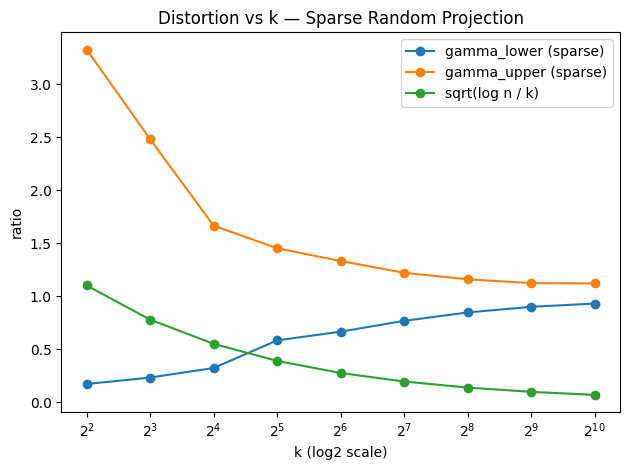

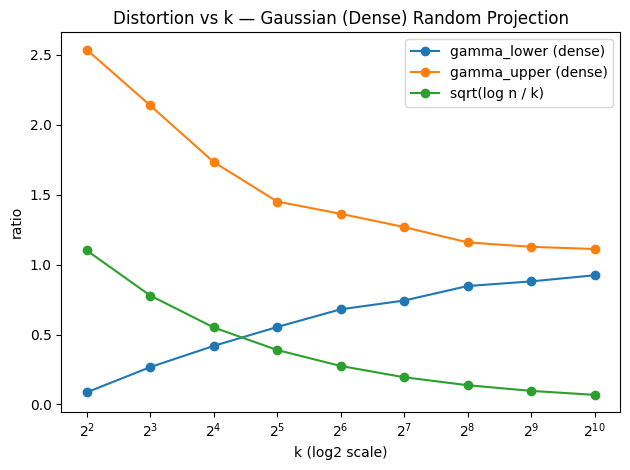

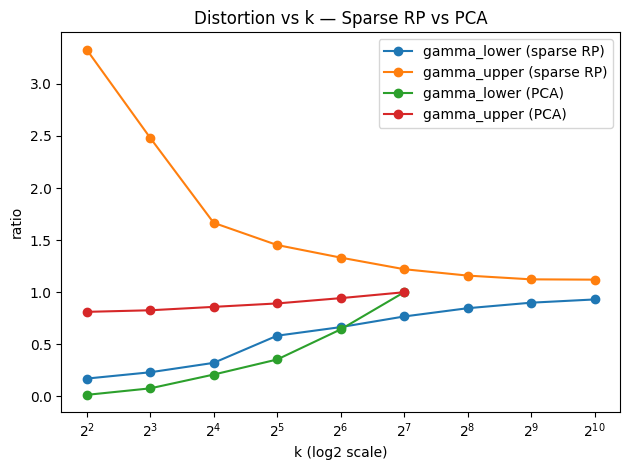

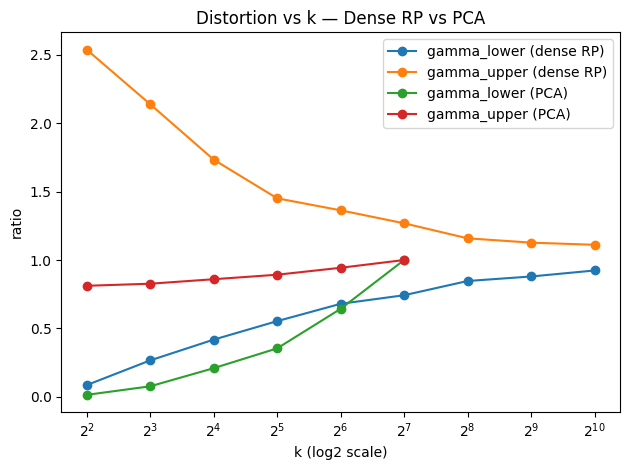

In [31]:
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA

# use functions from p3.py
def apply_sparse_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
    projector = SparseRandomProjection(n_components=num_projections)
    return projector.fit_transform(dataset)

def apply_dense_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
    projector = GaussianRandomProjection(n_components=num_projections)
    return projector.fit_transform(dataset)


# create high-dimensional dataset
X = create_high_dim_dataset(128, 2048).to_numpy(dtype=float)
n = X.shape[0]
d = X.shape[1]

# pairwise distance computation function
def pairwise_dists(A: np.ndarray) -> np.ndarray:
    G = A @ A.T
    sq = np.diag(G)
    D2 = sq[:, None] + sq[None, :] - 2 * G
    D2[D2 < 0] = 0.0
    return np.sqrt(D2, dtype=float)

D_orig = pairwise_dists(X)
i_upper = np.triu_indices(n, k=1)  # upper triangle indices (i<j)

# distortion computation function
def distortion_stats(projected: np.ndarray) -> tuple[float, float]:
    D_proj = pairwise_dists(projected)
    ratios = D_proj[i_upper] / (D_orig[i_upper] + 1e-12)
    return float(np.min(ratios)), float(np.max(ratios))

# initialize k values and results storage
k_list = [2**j for j in range(2, 11)]
pca_k_list = []
gamma_lower_sparse, gamma_upper_sparse = [], []
gamma_lower_dense, gamma_upper_dense = [], []
gamma_lower_pca,   gamma_upper_pca   = [], [] # for Q3
theory_vals = [np.sqrt(np.log(n) / k) for k in k_list]

for k in k_list:
    X_sparse = apply_sparse_random_projections(X, k)
    X_dense = apply_dense_random_projections(X, k)
    g_low_s, g_up_s = distortion_stats(X_sparse)
    g_low_d, g_up_d = distortion_stats(X_dense)

    gamma_lower_sparse.append(g_low_s)
    gamma_upper_sparse.append(g_up_s)
    gamma_lower_dense.append(g_low_d)
    gamma_upper_dense.append(g_up_d)

    # Q3: PCA distortion factors
    if k <= min(n, d): # to prevent ValueError: n_components=256 must be between 0 and min(n_samples, n_features)=128 with svd_solver='full'
        X_pca = PCA(n_components=k, random_state=0).fit_transform(X)
        pca_k_list.append(k)
        g_low_pca, g_up_pca = distortion_stats(X_pca)
        gamma_lower_pca.append(g_low_pca)
        gamma_upper_pca.append(g_up_pca)

# Q2 - sparse plot
plt.figure()
plt.plot(k_list, gamma_lower_sparse, marker="o", label="gamma_lower (sparse)")
plt.plot(k_list, gamma_upper_sparse, marker="o", label="gamma_upper (sparse)")
plt.plot(k_list, theory_vals,        marker="o", label="sqrt(log n / k)")
plt.xscale("log", base=2)
plt.xlabel("k (log2 scale)")
plt.ylabel("ratio")
plt.title("Distortion vs k — Sparse Random Projection")
plt.legend()
plt.tight_layout()

# Q2 - dense plot
plt.figure()
plt.plot(k_list, gamma_lower_dense, marker="o", label="gamma_lower (dense)")
plt.plot(k_list, gamma_upper_dense, marker="o", label="gamma_upper (dense)")
plt.plot(k_list, theory_vals,       marker="o", label="sqrt(log n / k)")
plt.xscale("log", base=2)
plt.xlabel("k (log2 scale)")
plt.ylabel("ratio")
plt.title("Distortion vs k — Gaussian (Dense) Random Projection")
plt.legend()
plt.tight_layout()

# --- Q3 plots: RP vs PCA on one shared figure (do both variants) ---
# Sparse RP vs PCA
plt.figure()
plt.plot(k_list, gamma_lower_sparse, marker="o", label="gamma_lower (sparse RP)")
plt.plot(k_list, gamma_upper_sparse, marker="o", label="gamma_upper (sparse RP)")
plt.plot(pca_k_list, gamma_lower_pca,    marker="o", label="gamma_lower (PCA)")
plt.plot(pca_k_list, gamma_upper_pca,    marker="o", label="gamma_upper (PCA)")
plt.xscale("log", base=2)
plt.xlabel("k (log2 scale)")
plt.ylabel("ratio")
plt.title("Distortion vs k — Sparse RP vs PCA")
plt.legend()
plt.tight_layout()

# Dense RP vs PCA
plt.figure()
plt.plot(k_list, gamma_lower_dense, marker="o", label="gamma_lower (dense RP)")
plt.plot(k_list, gamma_upper_dense, marker="o", label="gamma_upper (dense RP)")
plt.plot(pca_k_list, gamma_lower_pca,   marker="o", label="gamma_lower (PCA)")
plt.plot(pca_k_list, gamma_upper_pca,   marker="o", label="gamma_upper (PCA)")
plt.xscale("log", base=2)
plt.xlabel("k (log2 scale)")
plt.ylabel("ratio")
plt.title("Distortion vs k — Dense RP vs PCA")
plt.legend()
plt.tight_layout()

plt.show()

# Problem 4: Kaggle competition

In this problem, you will work on the [Diabetes Health Indicators dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset) from Kaggle. The dataset comprises responses to a CDC survey. The code in the cell below splits the dataset into features and labels, resulting in a binary classification task. For this problem, your only deliverable should be a Jupyter notebook that implements all the necessary code and addresses the following questions:

## Question 1

> The dataset contains numeric, nominal and ordinal features. Which features fall into which category, and how should we preprocess each category?

**Numeric:** age, alcohol_consumption_per_week, physical_activity_minutes_per_week, diet_score, sleep_hours_per_day, screen_time_hours_per_day, bmi, waist_to_hip_ratio, systolic_bp, diastolic_bp, heart_rate, cholesterol_total, hdl_cholesterol, ldl_cholesterol, triglycerides, glucose_fasting, glucose_postprandial, insulin_level, hba1c and binary features like family_history_diabetes, hypertension_history, cardiovascular_history

**Nominal:** gender, ethnicity, employment_status

**Ordinal:** education_level, income_level, smoking_status

For numeric features, we should preprocess them by standardizing so that models that are sensitive to feature scales perform better. We should also impute any missing numeric values using the mean or median of that feature.

For nominal features, we should impute any missing values using the mode of that feature, and then apply one-hot encoding to convert them into binary features instead of using arbitrary integer values.

For ordinal features, we should impute any missing values using the mode of that feature, and then map the categories to integers that reflect their order (e.g., for education_level: high school = 1, bachelor's = 2, master's = 3, PhD = 4).

## Question 2

> Train a classifier for the binary classification task, and report the average accuracy and Area-Under-Curve (AUC) using 5-fold cross-validation. Does this problem warrant using additional metrics, such as the F1 score, in addition to accuracy? Why or why not?

> **Note**: You are allowed to choose any model suitable for binary classification you want, in addition to those you have already seen in class. You are welcome to peruse the scikit-learn documentation for additional models, if you want to try them out.

Code and results are at the end of this problem.

## Question 3

> If you wanted to further improve the performance of your classifier for this problem, what additional methods / model improvements would you consider and why?

The Logistic Regression model achieved a ROC-AUC of 0.93 and an F1 score of 0.88, while the Decision Tree had slightly higher accuracy (0.863) but notably lower ROC-AUC (0.855). This suggests that Logistic Regression is better at ranking positive vs negative classes, while the Decision Tree may be overfitting slightly.

To improve model performance, I would firstly consider hyperparameter tuning for both Logistic Regression (like adjusting C for regularization) and Decision Tree (like tuning max_depth, min_samples_split, and min_samples_leaf) to reduce overfitting and find a better bias–variance tradeoff. Another simple but effective improvement could be threshold tuning, where we adjust the probability cutoff (instead of using the default 0.5) to maximize metrics like F1 or recall, which is especially relevant in medical prediction tasks.

Additionally, I think some moderate feature engineering (e.g., risk flags, interaction terms, ratios) can further boost model expressiveness without adding much complexity.

In [32]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = os.path.join(
    kagglehub.dataset_download("mohankrishnathalla/diabetes-health-indicators-dataset"),
    "diabetes_dataset.csv",
)
df = pd.read_csv(path)

# Define the feature and labels
# We want to solve the binary classification task, drop the other two labels
features = df.drop(columns=["diabetes_risk_score", "diabetes_stage", "diagnosed_diabetes"])
labels = df["diagnosed_diabetes"]

In [33]:
pd.set_option('display.max_columns', None)
features.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20


In [34]:
labels.head()

0    1
1    0
2    1
3    1
4    1
Name: diagnosed_diabetes, dtype: int64

In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


numeric_features = [
    "age", "alcohol_consumption_per_week", "physical_activity_minutes_per_week",
    "diet_score", "sleep_hours_per_day", "screen_time_hours_per_day",
    "bmi", "waist_to_hip_ratio", "systolic_bp", "diastolic_bp", "heart_rate",
    "cholesterol_total", "hdl_cholesterol", "ldl_cholesterol", "triglycerides",
    "glucose_fasting", "glucose_postprandial", "insulin_level", "hba1c",
    # binary indicators treated as numeric (no encoding):
    "family_history_diabetes", "hypertension_history", "cardiovascular_history"
]

ordinal_features = ["education_level", "income_level", "smoking_status"]
ordinal_orders = [
    ["Primary", "Middle-School", "Highschool", "Undergraduate", "Graduate"],
    ["Low", "Lower-Middle", "Middle", "Upper-Middle", "High"],
    ["Never", "Former", "Current"]
]

nominal_features = ["gender", "ethnicity", "employment_status"]

# preprocessing
# numeric: mean/median imputation + standardization
numeric_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# ordinal: mode imputation + map ordered categories to integers
ordinal_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=ordinal_orders,
                               handle_unknown="use_encoded_value", unknown_value=-1))
])

# nominal: mode imputation + one-hot
nominal_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pre, numeric_features),
    ("ord", ordinal_pre, ordinal_features),
    ("nom", nominal_pre, nominal_features)
])

# evaluate logistic regression and decision tree
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# cross-validation setup and metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "roc_auc", "f1"]

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    cvres = cross_validate(pipe, features, labels, cv=cv, scoring=scoring, n_jobs=-1)
    results[name] = {m: np.mean(cvres[f"test_{m}"]) for m in scoring}

print(pd.DataFrame(results).T)

                     accuracy   roc_auc        f1
Logistic Regression   0.85912  0.934003  0.883995
Decision Tree         0.86342  0.855328  0.887265
